<a href="https://colab.research.google.com/github/tomonari-masada/course2024-stats2/blob/main/04_NumPyro_2_(example).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NumPyro入門 (2)
* 今回は、NumPyroの以下のチュートリアルを使う。
 * https://num.pyro.ai/en/stable/tutorials/bayesian_regression.html

## 準備

In [ ]:
!pip install numpyro

In [ ]:
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

plt.style.use("bmh")
%config InlineBackend.figure_format = 'retina'

rng_key = random.PRNGKey(0)

numpyro.set_platform("cpu")

2024-06-19 20:43:07.319301: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.3 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## NumPyroによるMCMC

### MCMC（マルコフ連鎖モンテカルロ）とは
* ベイズ的なモデリングにおいて、事後分布を知ろうとする方法の一つ。
  * もう一つの方法に、変分推論(variational inference)がある。
* MCMCは、事後分布からのサンプルを通して、事後分布そのものを知ろうとする方法。
* モデルが複雑になるほど、事後分布$p(\theta|X)$からのサンプリングは、難しくなっていく。
  * 比較的シンプルなモデルについては、うまいサンプリング手法を構成できる（例: LDAのcollapsed Gibbs sampling）。
* この授業では、MCMCの使い方を実践的に説明する。細かい理屈はあまり説明しない。
  * MCMCの解説としては https://arxiv.org/abs/1701.02434 などを参照のこと。

## 例題: The Spurious Waffles
* このデータセットについては、下のスライドを参照のこと。
  * https://speakerdeck.com/rmcelreath/l05-statistical-rethinking-winter-2019


* USの各州でのワッフル・ハウスというレストランの店舗数と、離婚率とに、正の相関がある？
* もちろんこれは、擬似連関(spurious association)。
  * 「連関(association)」: https://bellcurve.jp/statistics/glossary/735.html
  * https://www.tylervigen.com/spurious-correlations
  * 実際には、ワッフル・ハウスの店舗数に影響を与える他の要因と、離婚率との間に、相関がある。
  * なお、associationとcorrelationという言葉はあまり区別せず使われる。
  * だが、correlationの方を特にlinearな連関に限定した意味で使うことがある。
* ここでは、擬似連関の分析には深入りしない。
* ベイズ回帰をNumPyroでどのように実装するかを説明するために、このデータセットを使う。

In [ ]:
DATASET_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/WaffleDivorce.csv"
dset = pd.read_csv(DATASET_URL, sep=";")
dset

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.450000
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.000000
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.000000
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.260000
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.000000
5,Colorado,CO,5.03,25.7,23.5,1.24,11.6,0.94,11,0,0,34277,0.000000
6,Connecticut,CT,3.57,27.6,17.1,1.06,6.7,0.77,0,0,0,460147,0.000000
7,Delaware,DE,0.90,26.6,23.1,2.89,8.9,1.39,3,0,1798,112216,0.016000
8,District of Columbia,DC,0.60,29.7,17.7,2.53,6.3,1.89,0,0,0,75080,0.000000
9,Florida,FL,18.80,26.4,17.0,0.58,8.5,0.32,133,1,61745,140424,0.440000


### EDA

* ペアプロットで主要な変数どうしの関係を可視化する。

/home/masada/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/masada/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/masada/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/masada/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

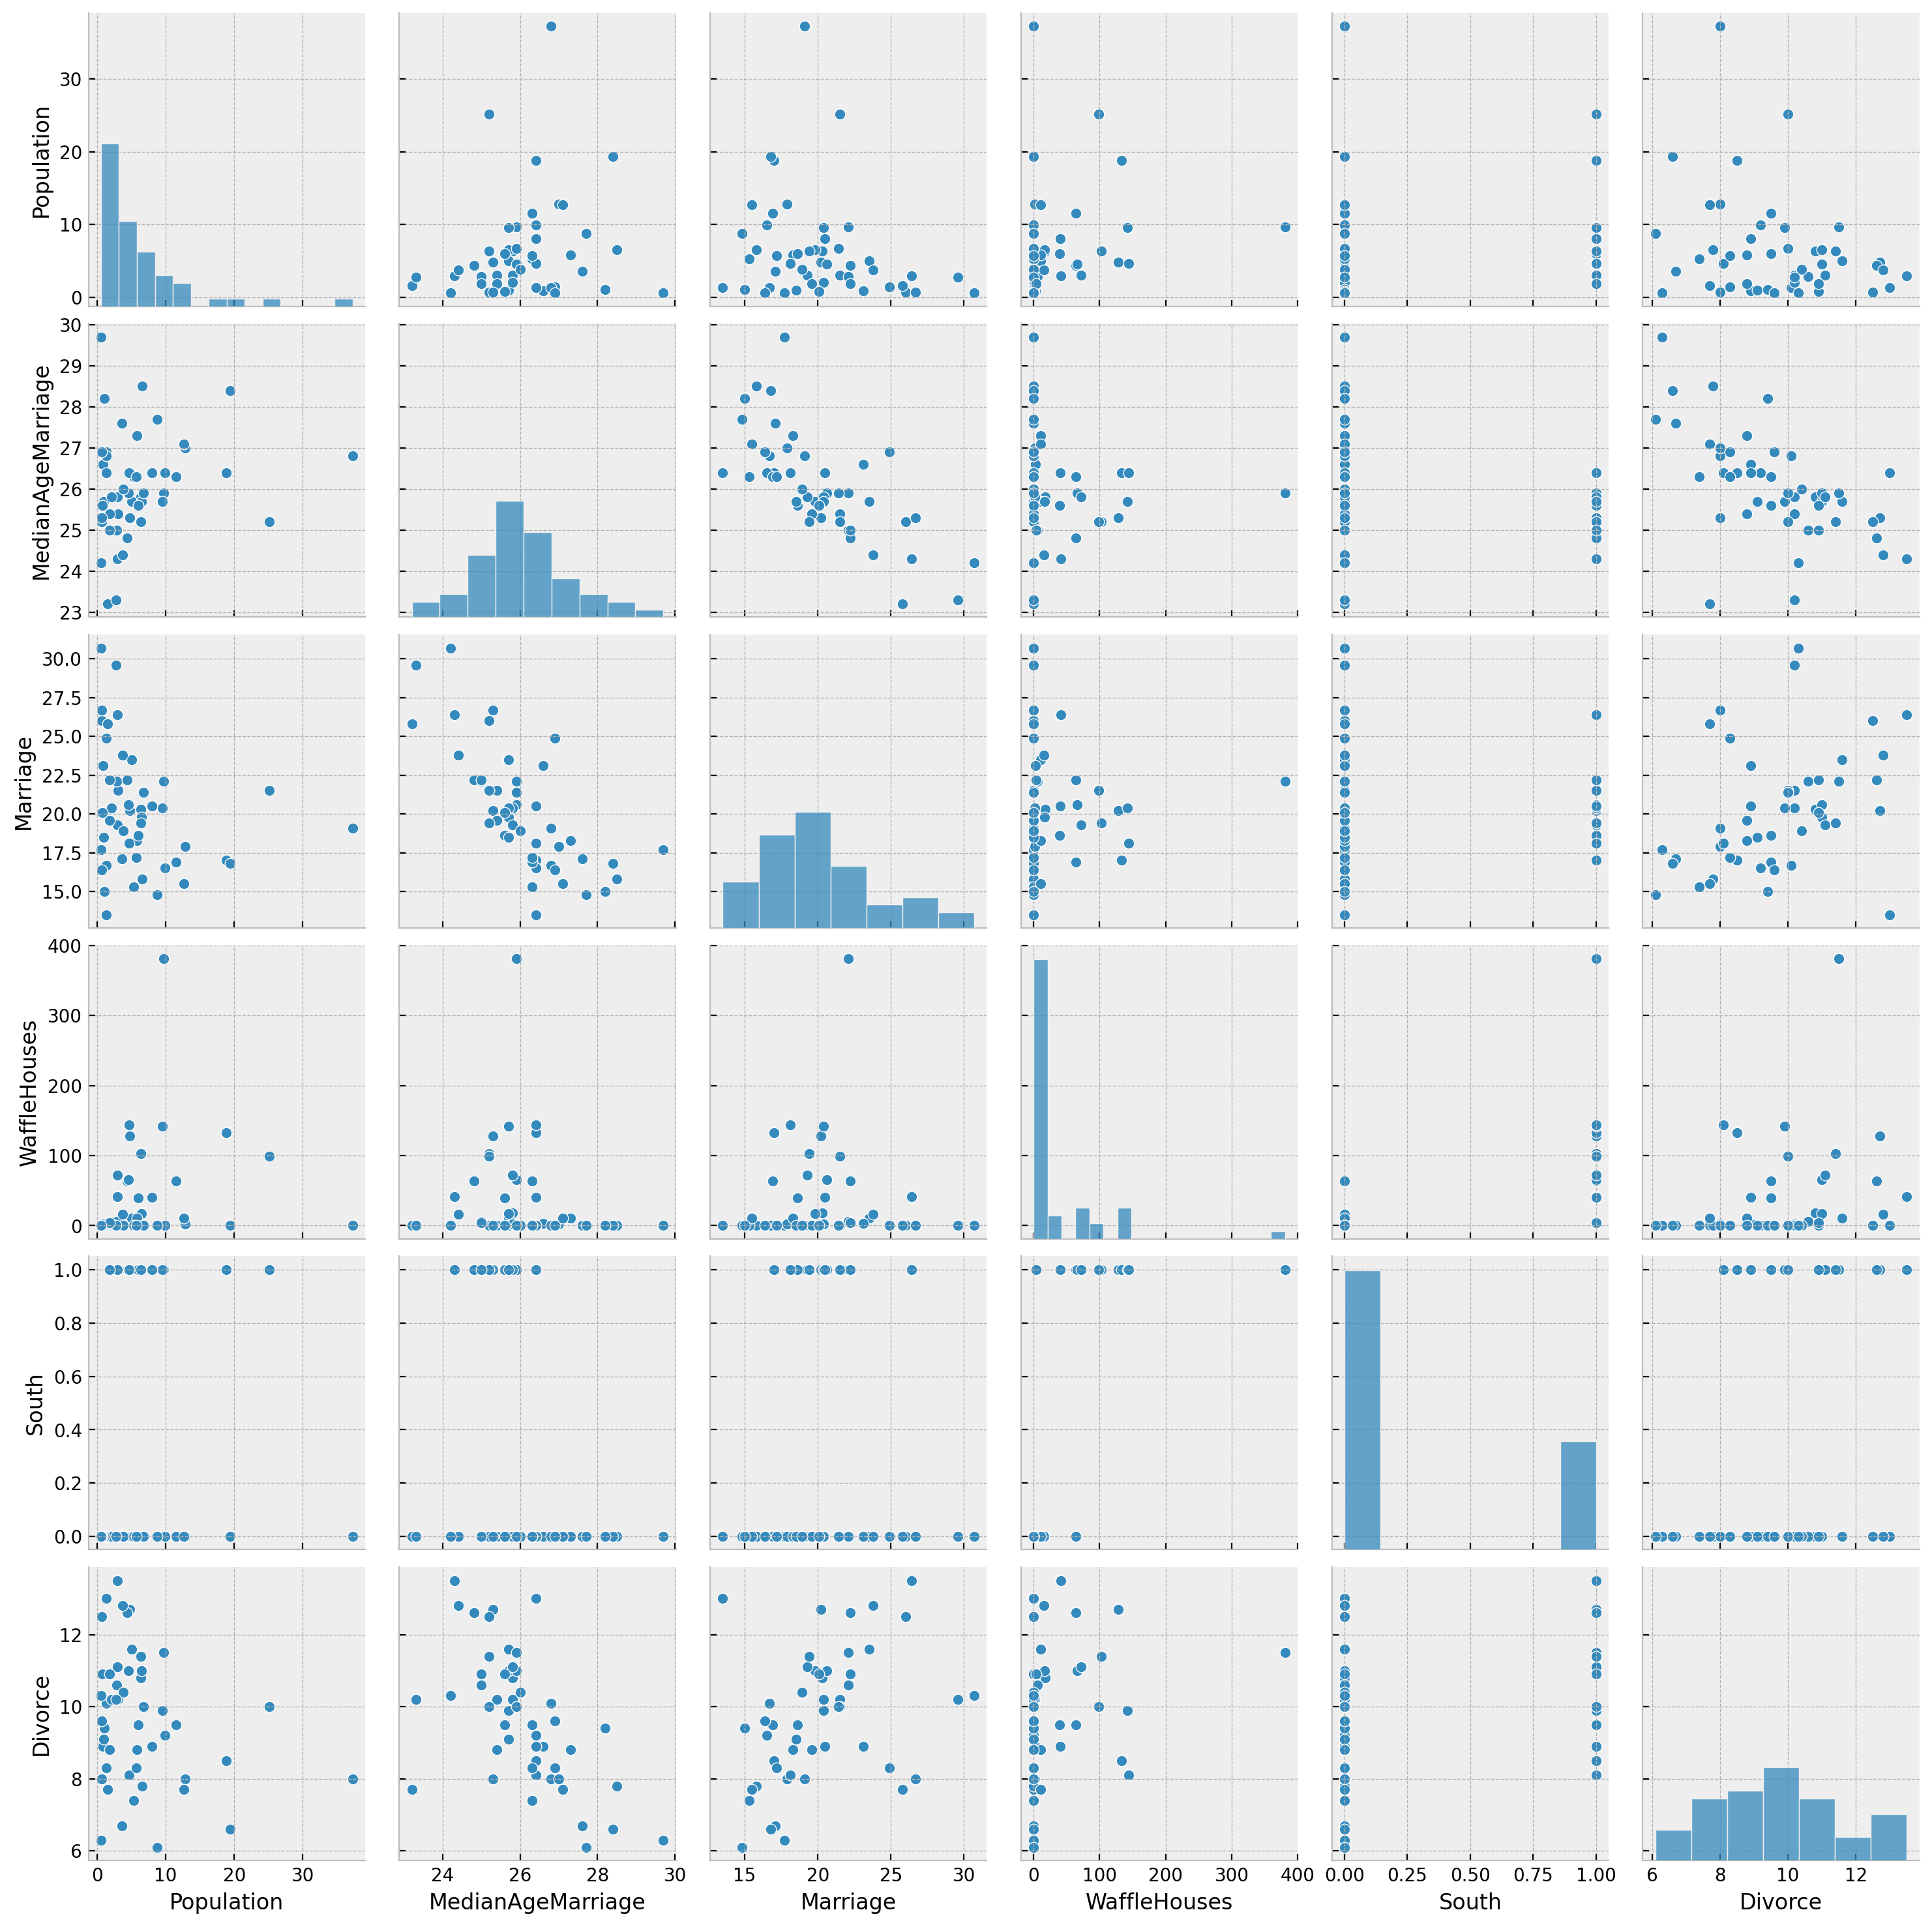

In [ ]:
vars = [
    "Population",
    "MedianAgeMarriage",
    "Marriage",
    "WaffleHouses",
    "South",
    "Divorce",
]
sns.pairplot(dset, x_vars=vars, y_vars=vars);

* ペアプロットから得られる観察
  * 離婚率と婚姻率の間には連関がありそう。
  * 離婚率と婚姻年齢の中央値の間にも連関がありそう。

* 問題の、離婚率とWaffle Houseの店舗数との連関を、seabornの`regplot`で可視化してみる。

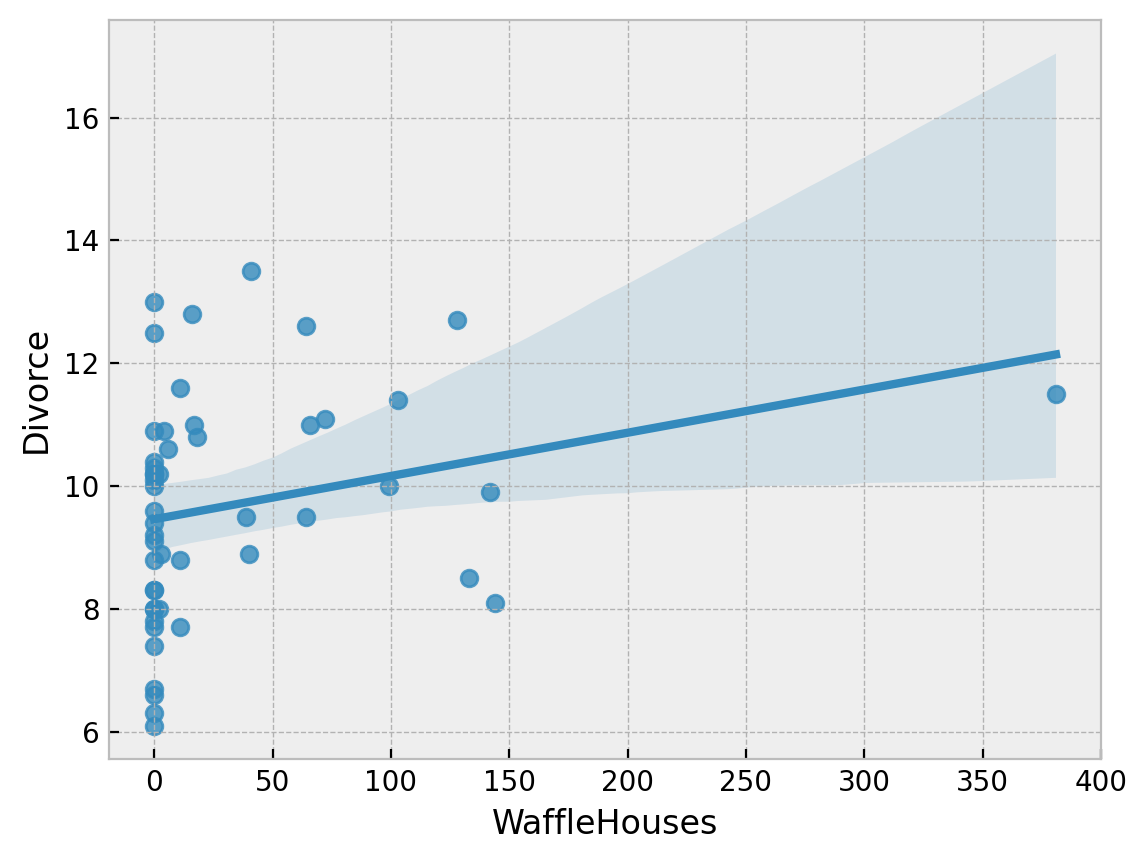

In [ ]:
sns.regplot(x="WaffleHouses", y="Divorce", data=dset);

* この擬似連関ついては、下記の教科書の5,6章に議論があるらしい。
  * McElreath, R. (2016). [Statistical Rethinking](https://xcelab.net/rm/statistical-rethinking/): A Bayesian Course with Examples in R and Stan CRC Press.

### 今回の問題設定
* ここでは、離婚率を、以下の2つの説明変数(predictor)で予測することを考える。
  * 婚姻率 ("MarriageScaled")
  * 婚姻年齢の中央値 ("AgeScaled")


### データの標準化(standardization)
* https://mc-stan.org/docs/stan-users-guide/standardizing-predictors-and-outputs.html
* 標準化しなくても、MCMCが問題なく実行できることも結構ある。

In [ ]:
standardize = lambda x: (x - x.mean()) / x.std()

dset["AgeScaled"] = dset.MedianAgeMarriage.pipe(standardize)
dset["MarriageScaled"] = dset.Marriage.pipe(standardize)
dset["DivorceScaled"] = dset.Divorce.pipe(standardize)

* 標準化した後の値を確認。

/home/masada/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/masada/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/masada/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


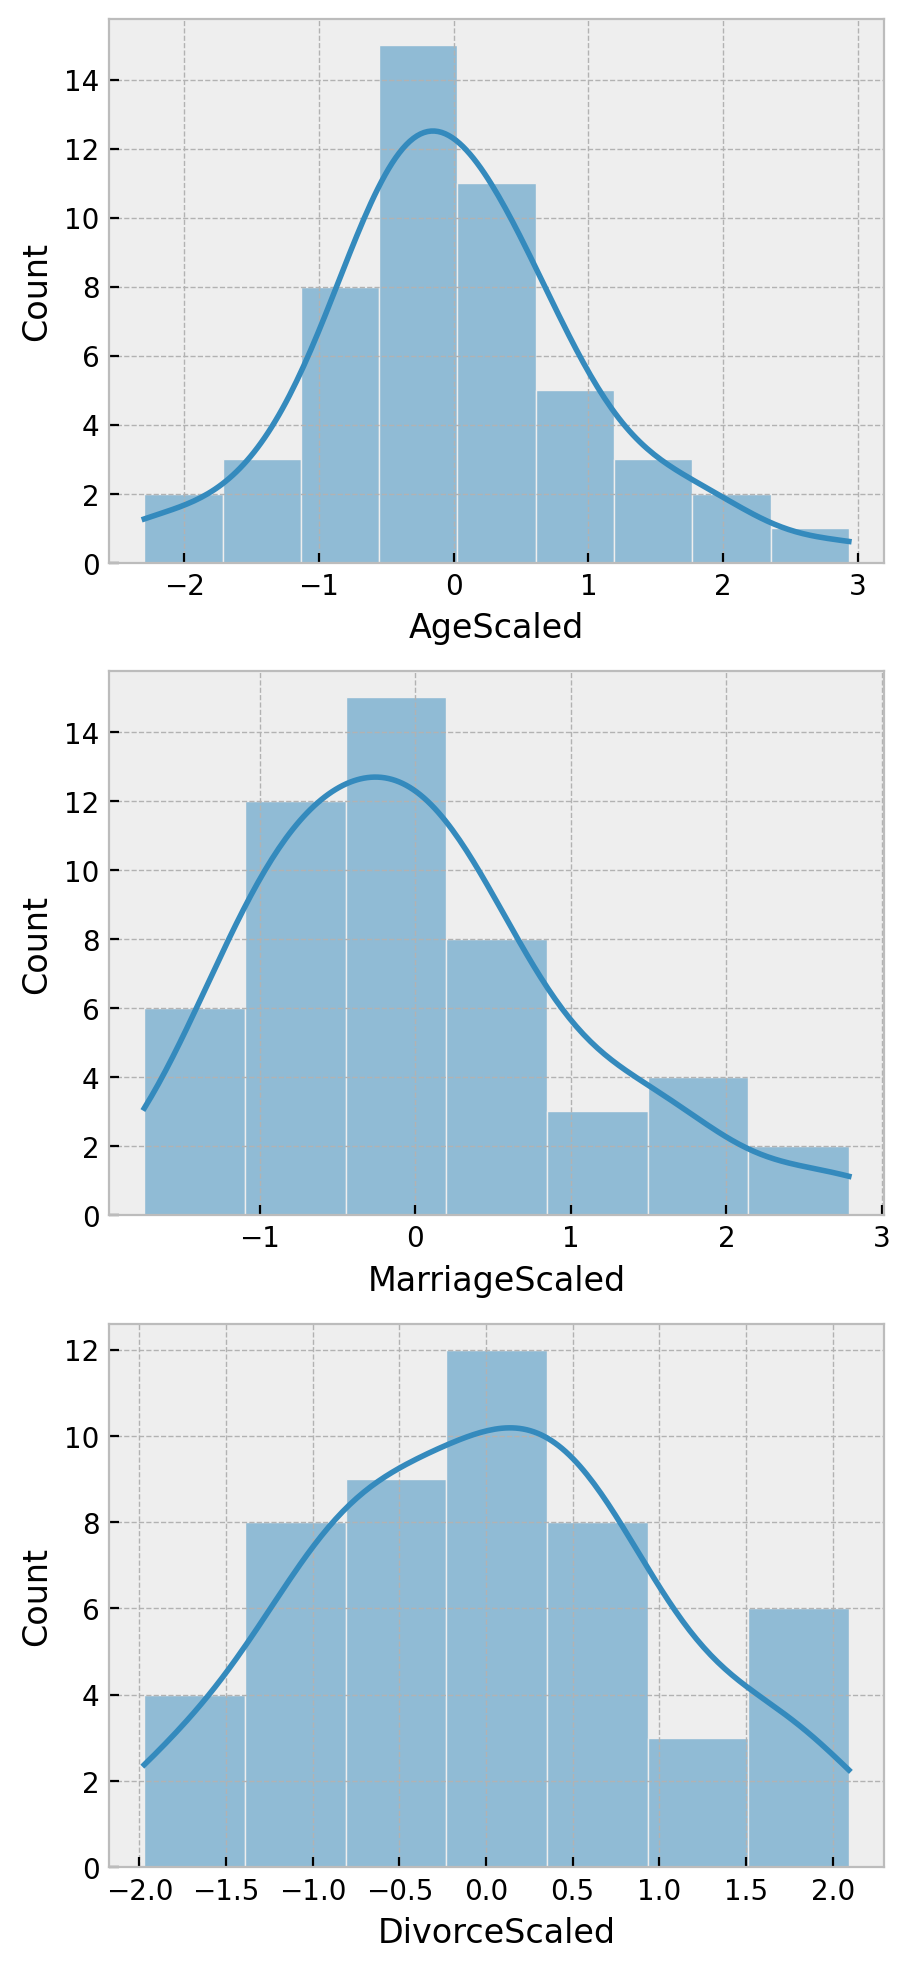

In [ ]:
fig, axs = plt.subplots(3, figsize=(5, 12))
for i, x in enumerate(["AgeScaled", "MarriageScaled", "DivorceScaled"]):
  sns.histplot(dset, x=x, kde=True, ax=axs[i]);

### statsmodelsによる回帰分析
* ベイズではない、いつもの回帰分析。

In [ ]:
import statsmodels.api as sm

model = sm.OLS(dset["DivorceScaled"], dset[["MarriageScaled", "AgeScaled"]])
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          DivorceScaled   R-squared (uncentered):                   0.363
Model:                            OLS   Adj. R-squared (uncentered):              0.337
Method:                 Least Squares   F-statistic:                              13.70
Date:                Wed, 19 Jun 2024   Prob (F-statistic):                    1.96e-05
Time:                        20:43:11   Log-Likelihood:                         -59.150
No. Observations:                  50   AIC:                                      122.3
Df Residuals:                      48   BIC:                                      126.1
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
MarriageScaled    -0.1186      0.166     -0.714      0.479      -0.453       0.216
AgeScaled         -0.6828      0.166     -4.108      0.000      -1.017      -0.349
==============================================================================
Omnibus:                        2.545   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.280   Jarque-Bera (JB):                1.595
Skew:                          -0.301   Prob(JB):                        0.450
Kurtosis:                       3.635   Cond. No.                         2.48
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 離婚率を予測するベイズ線形回帰モデル
* ベイズ回帰では、説明変数の係数がなんらかの事前分布に従うと仮定する。
  * ここでは、係数は正規分布に従うと仮定する。


### モデルの構成
* 離婚率を表す変数を$y$とする。この$y$が目的変数。
* 婚姻率を表す変数を$x_M$、婚姻年齢の中央値を表す変数を$x_A$とする。これらは説明変数。
* 今回使うモデルの構成を式で書くと、以下のようになる。
$$\begin{align}
a & \sim N(0, 0.2^2) \\
b_M & \sim N(0, 0.5^2) \\
b_A & \sim N(0, 0.5^2) \\
\sigma & \sim \mbox{Exp}(1) \\
\mu & \equiv a + b_M x_M + b_A x_A \\
y & \sim N(\mu, \sigma^2)
\end{align}$$

### モデルの実装
* NumPyroでは、モデルは関数として定義される。
* 目的変数はオプション引数としておく方が良い。
 * その理由は、じわじわ分かってくる。
* 今回、説明変数もオプション変数にしているのには、別の理由がある。
 * こうすると、一部の説明変数を使わないモデリングの際にも、同じ関数を使いまわせる。
* 係数が従う正規分布の標準偏差（NumPyroの言葉ではscale）は、この値でないといけないというわけではない。
 * 事前分布のパラメータ（ハイパーパラメータ）をどう設定するかは、常に問題になる。

In [ ]:
def model(marriage=None, age=None, divorce=None):
  a = numpyro.sample("a", dist.Normal(0.0, 0.2))
  M, A = 0.0, 0.0
  if marriage is not None:
    bM = numpyro.sample("bM", dist.Normal(0.0, 0.5))
    M = bM * marriage
  if age is not None:
    bA = numpyro.sample("bA", dist.Normal(0.0, 0.5))
    A = bA * age
  sigma = numpyro.sample("sigma", dist.Exponential(1.0))
  mu = a + M + A
  numpyro.sample("obs", dist.Normal(mu, sigma), obs=divorce)

## モデル1: 婚姻率による予測
* 説明変数として婚姻率のみを使うモデリングをしてみる。
* 関数`model`では、説明変数をオプション引数にしたので、使用する変数にだけ値を設定すれば、使いまわしができる。

### MCMCの実行

* NUTS (No-U-Turn-Sampler) は、よく使われるサンプラー。
  * HMCの改良版。詳細は割愛するが、おおよその説明は後ほど。
  * https://mc-stan.org/docs/reference-manual/hmc.html
  * https://arxiv.org/abs/1111.4246

In [ ]:
rng_key, rng_key_ = random.split(rng_key)

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000)
mcmc.run(
    rng_key_, marriage=dset.MarriageScaled.values, divorce=dset.DivorceScaled.values
)

sample: 100%|██████████| 3000/3000 [00:06<00:00, 467.43it/s, 5 steps of size 6.75e-01. acc. prob=0.94]


* chainとは、サンプルの一つの系列のこと。デフォルトではchainは一つだけ。
* MCMCによるサンプリングでは、直前のサンプルを少し変化させることで、次のサンプルを求める。
 * 前回説明したとおり、この変化のさせ方が賢いので、ちゃんと事後分布からのサンプルになる。
* ということは、サンプルは、初期値から始まる一筋の系列をなしている。この系列をchainと呼ぶ。
* 複雑なモデルの場合は、複数のchainを走らせることが多い。
 * 複雑なモデルだと、事後分布からのサンプリングも複雑になる。
 * そのため、複数のchainを比較して、うまくサンプリングができているかをチェックしたりする。

* サンプルの統計量を見てみる。

In [ ]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.00      0.11     -0.00     -0.19      0.17   1674.85      1.00
        bM      0.35      0.13      0.35      0.14      0.56   1756.94      1.00
     sigma      0.95      0.10      0.94      0.79      1.12   1632.67      1.00

Number of divergences: 0


**注意** divergenceが0でなかったら、色々と考え直す必要がある。（後の回で説明します。）


* サンプルを取得する。

In [ ]:
samples_1 = mcmc.get_samples()
samples_1

{'a': Array([-0.14133626,  0.03742786, -0.01145333, ..., -0.24789912,
        -0.13843203, -0.03234433], dtype=float32),
 'bM': Array([0.38371173, 0.30629987, 0.3563512 , ..., 0.2486265 , 0.19559501,
        0.33484173], dtype=float32),
 'sigma': Array([0.8806394 , 0.82902086, 1.1300346 , ..., 1.0468063 , 0.9169351 ,
        0.9547113 ], dtype=float32)}

* サンプルはJAXの配列になっている。

In [ ]:
type(samples_1['a'])

jaxlib.xla_extension.ArrayImpl

* Numpyのndarrayに変換することもできる。

In [ ]:
type(np.array(samples_1['a']))

numpy.ndarray

### サンプルの可視化

* 事後分布からのサンプル全体をpandasのデータフレームに変換する。

In [ ]:
df_samples_1 = pd.DataFrame.from_dict(samples_1)
df_samples_1

,a,bM,sigma
0,-0.141336,0.383712,0.880639
1,0.037428,0.306300,0.829021
2,-0.011453,0.356351,1.130035
3,-0.059615,0.327725,1.009282
4,-0.076388,0.488213,1.001237
...,...,...,...
1995,0.119589,0.401145,1.038094
1996,-0.215191,0.248622,0.896163
1997,-0.247899,0.248627,1.046806
1998,-0.138432,0.195595,0.916935


* サンプルのヒストグラムを描くと、事後分布の大体の形が分かる。
  * seabornでヒストグラムを描いてみる。

/home/masada/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


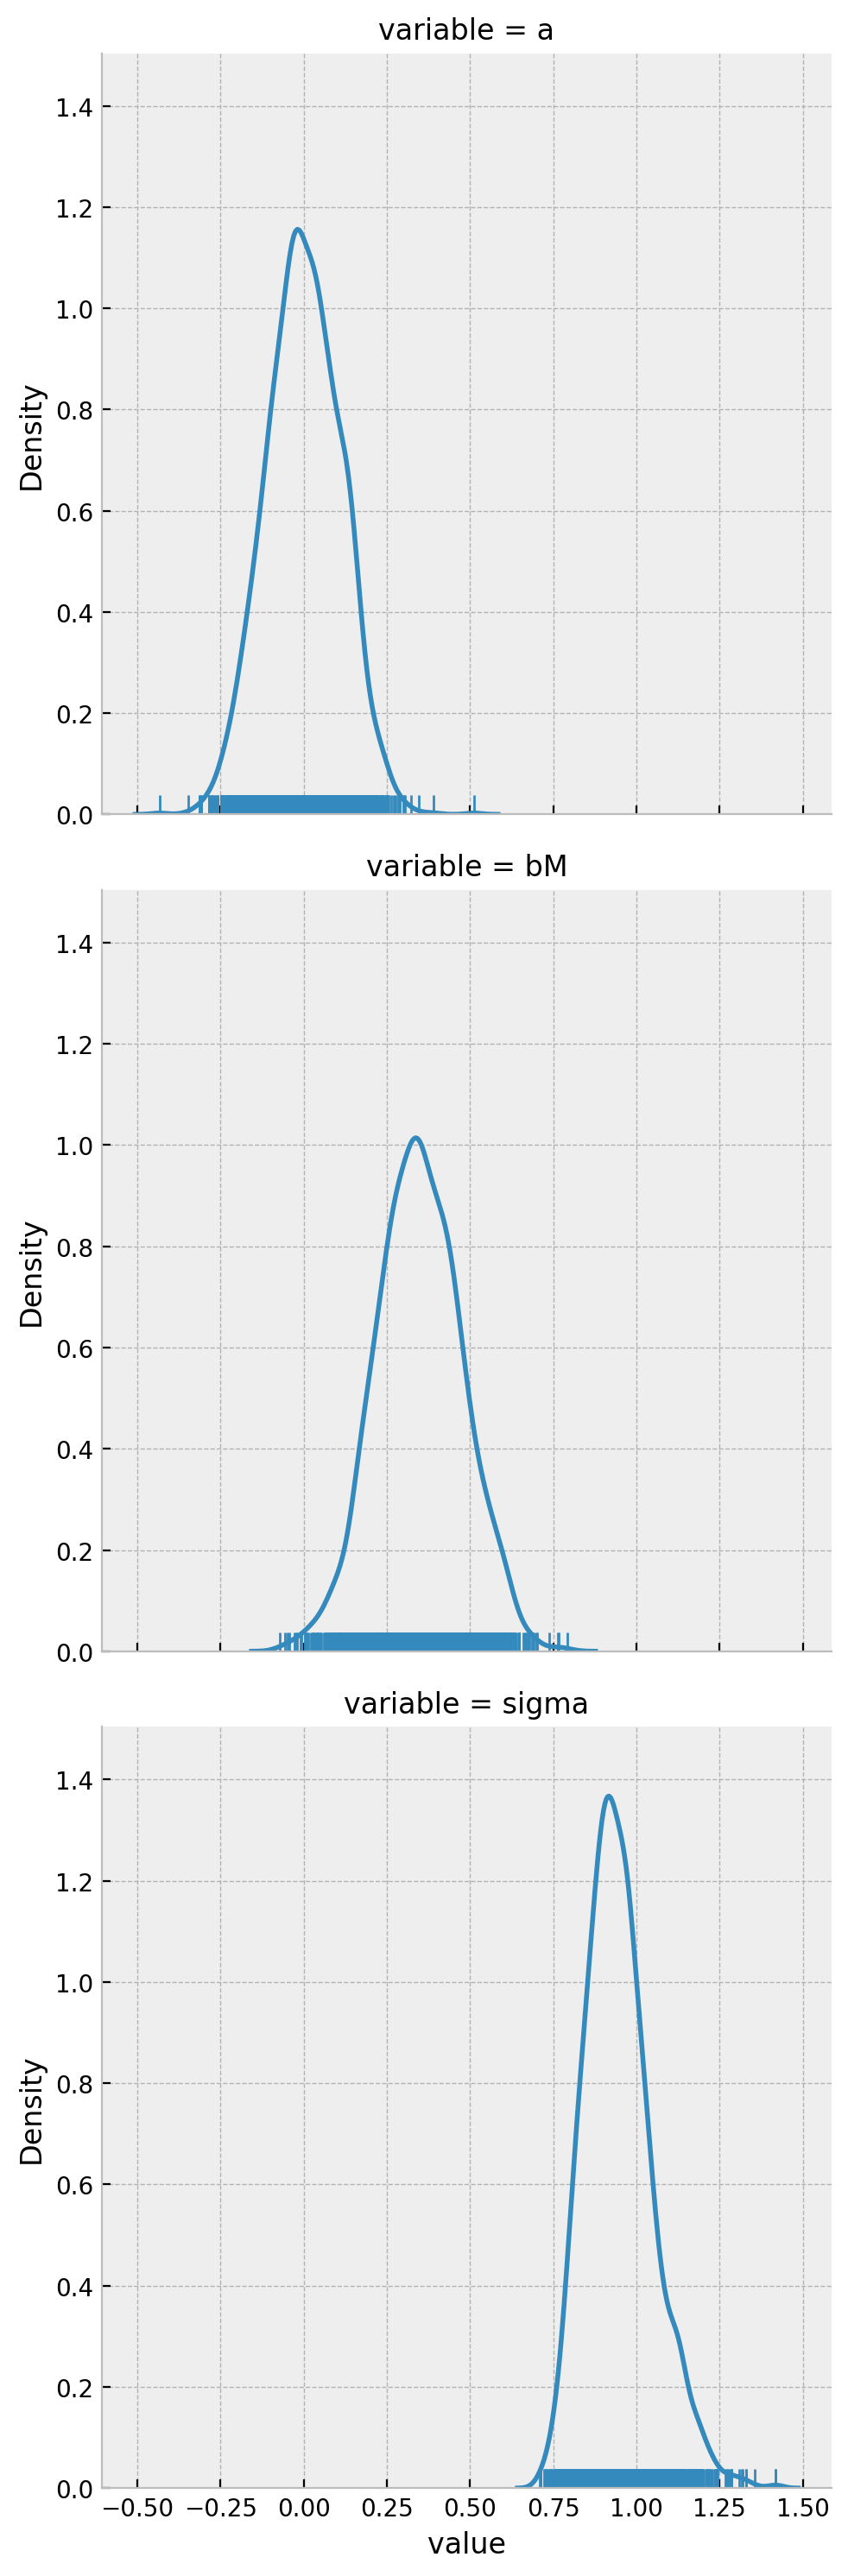

In [ ]:
sns.displot(
    df_samples_1.melt(),
    x="value", row="variable",
    kind="kde", rug=True,
    );

* もちろん、ArviZを使ってもよい。

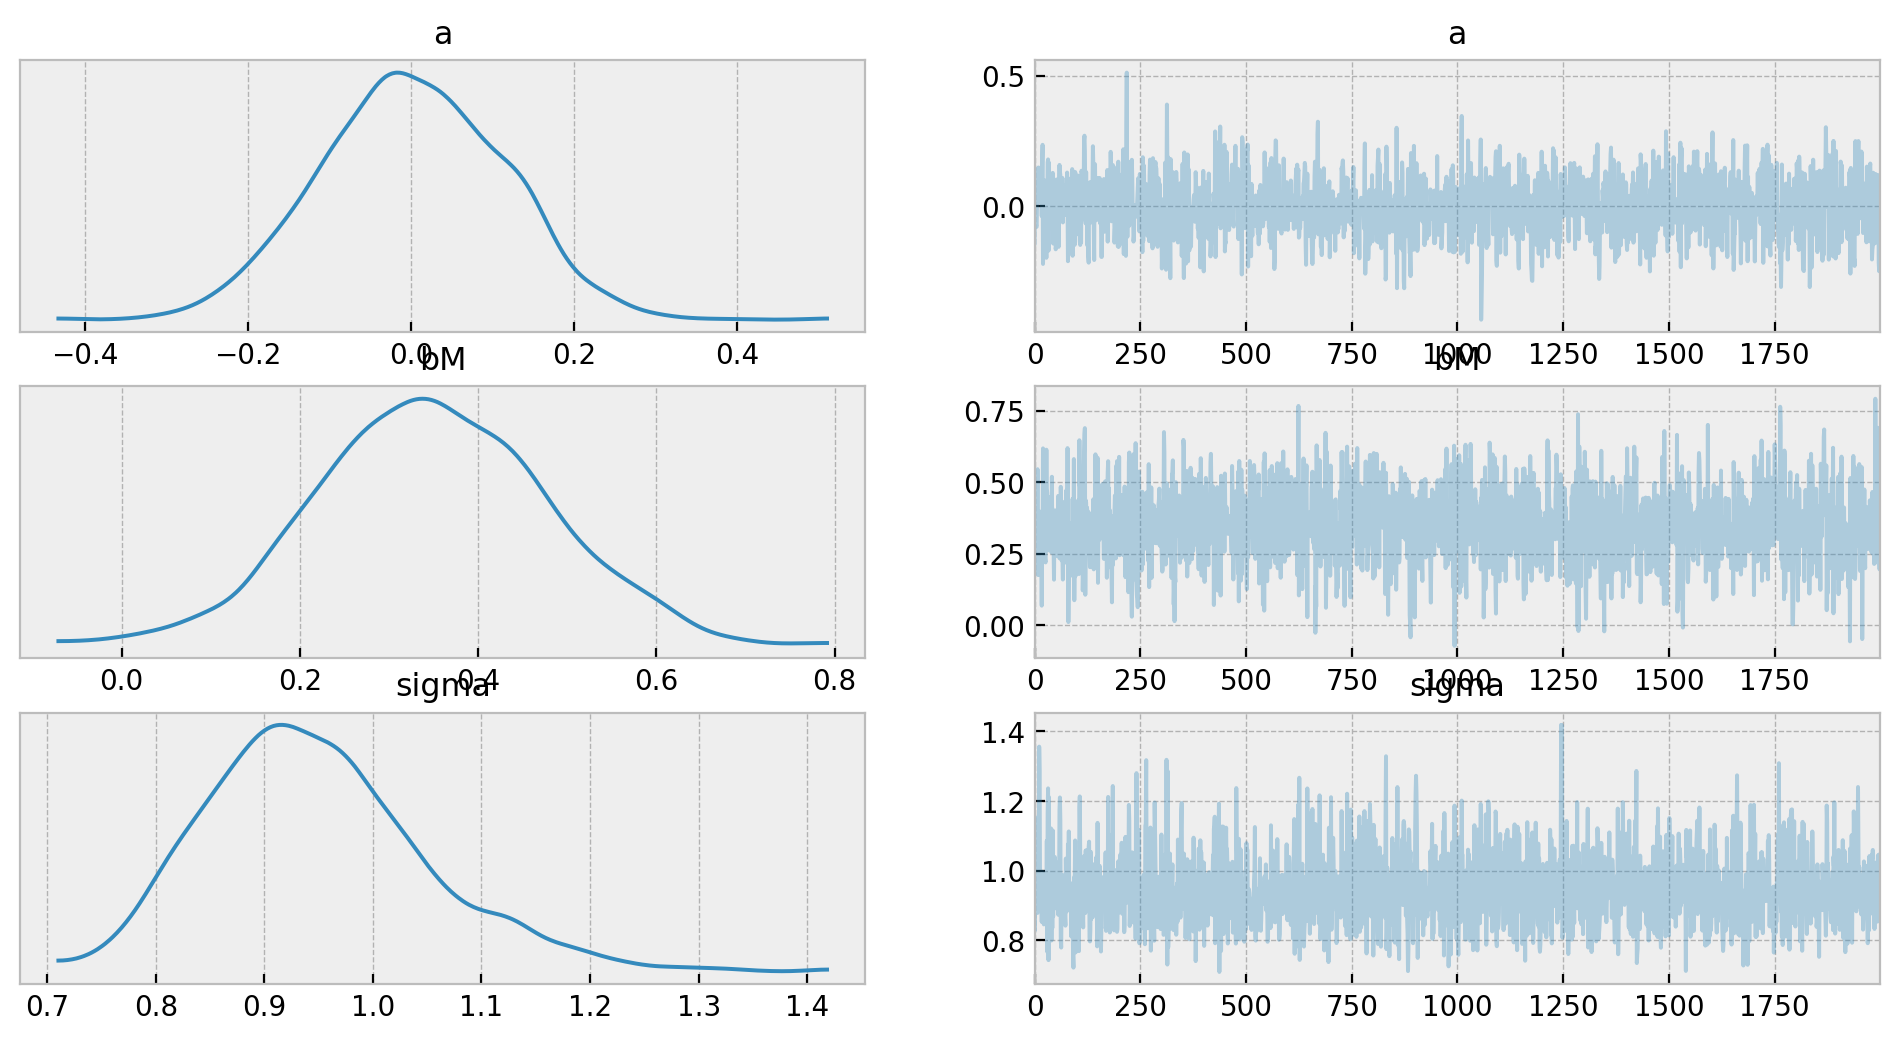

In [ ]:
import arviz as az
az.plot_trace(az.from_numpyro(mcmc));

### 目的変数の期待値の信用区間
* 信用区間 (credible interval) については、例えば下記のWebページを参照のこと。
  * https://statswithr.github.io/book/introduction-to-bayesian-regression.html

* 線形回帰によるモデリングを表す式
  * $\sigma$は誤差項。
$$\begin{align} y = a + b_M x_M + \sigma \end{align}$$

* $i$を観測データのインデックスとする。
  * つまり、州の通し番号。

* 説明変数の値が$x_{M,i}$のときの目的変数の（誤差が従う分布について求められる）期待値は
$$\begin{align}\mu_i \equiv E_{\sigma}[y | x_{M,i}] = E_{\sigma}[a + b_M x_{M,i} + \sigma] = a + b_M x_{M,i}\end{align}$$

* 事後分布からの特定のサンプル$(a^{(s)}, b_M^{(s)})$を使って求めた目的変数の期待値は
$$\begin{align}\mu_i^{(s)} = a^{(s)} + b_M^{(s)} x_{M,i}\end{align}$$

* 説明変数の値が$x_{M,i}$のときの目的変数の期待値の（切片と係数が従う事後分布について求められる）期待値
$$\begin{align} E_{a, b_M}[\mu_i] \approx \frac{1}{S} \sum_s \mu_i^{(s)} = \frac{1}{S} \sum_s ( a^{(s)} + b_M^{(s)} x_{M,i} )\end{align}$$
  * $\approx$のところでモンテカルロ近似をしている。

* 50州の標準化された婚姻率それぞれについて、サンプル毎に回帰式を計算する。

In [ ]:
posterior_mu = (
    jnp.expand_dims(samples_1["a"], -1)
    + jnp.expand_dims(samples_1["bM"], -1) * dset.MarriageScaled.values
)
posterior_mu.shape

(2000, 50)

* 上の計算により、標準化された婚姻率の様々な値に対して、離婚率の期待値がどのように散らばっているかが求められている。
* この結果を使って、標準化された婚姻率の様々な値に対して、対応する離婚率の期待値の、平均とHPDIを求める。

In [ ]:
mean_mu = jnp.mean(posterior_mu, axis=0)
hpdi_mu = hpdi(posterior_mu, 0.9)

* 下のヘルパ関数を使って、目的変数の期待値の90%信用区間を描画する。
* 90%信用区間は、90% highest posterior density interval (HPDI)として求めている。
 * https://num.pyro.ai/en/stable/diagnostics.html#hpdi
 * 切片や係数のHPDIを求めて、回帰式に当てはめればよい。

In [ ]:
def plot_regression(x, y_mean, y_hpdi):
  # Sort values for plotting by x axis
  idx = jnp.argsort(x)
  marriage = x[idx]
  mean = y_mean[idx]
  hpdi = y_hpdi[:, idx]
  divorce = dset.DivorceScaled.values[idx]

  # Plot
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
  ax.plot(marriage, mean)
  ax.plot(marriage, divorce, "o")
  ax.fill_between(marriage, hpdi[0], hpdi[1], alpha=0.3, interpolate=True)
  return ax

* そして、ヘルパ関数を呼び出し、可視化する。

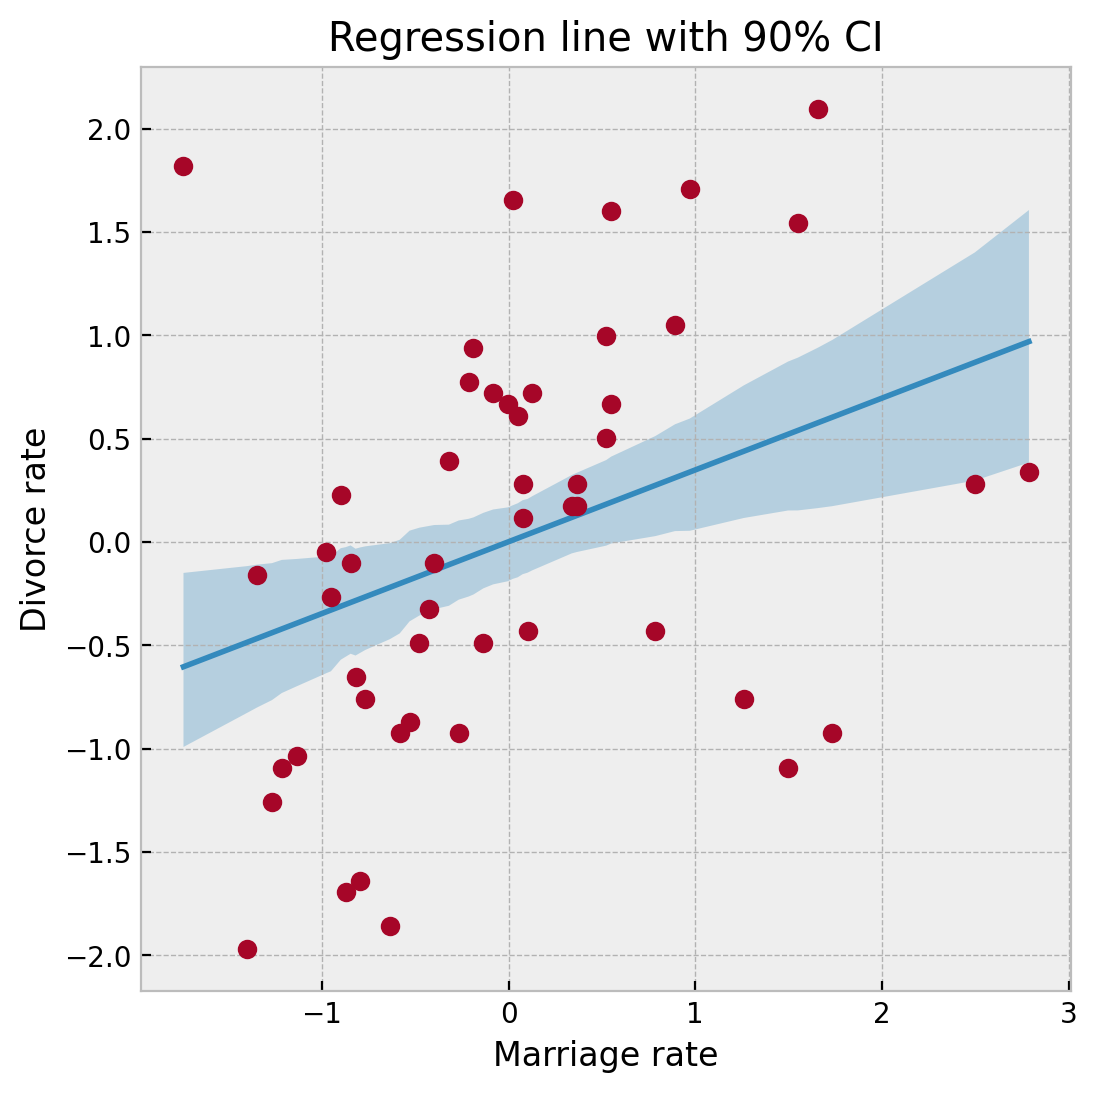

In [ ]:
ax = plot_regression(dset.MarriageScaled.values, mean_mu, hpdi_mu)
ax.set(
    xlabel="Marriage rate", ylabel="Divorce rate", title="Regression line with 90% CI",
);

### 目的変数の予測値の信用区間

#### 予測分布とは
* ベイズ的モデリングで、事後分布を求めてどうするのか・・・という話を前回した。
* 事後分布に関して、$\theta$の関数$f(\theta)$の期待値を計算することが、しばしばある。
$$ E_{p(\theta|X)}[f(\theta)] = \int f(\theta) p(\theta|X) d\theta$$
 * 例： $f(\theta)$として、データのモデリングに使っている尤度関数$p(x|\theta)$を持ってくると、上の式は予測分布$p(x|X)$を表す。
$$ E_{p(\theta|X)}[p(x|\theta)] = \int p(x|\theta) p(\theta|X) d\theta = p(x|X)$$


#### 予測分布のモンテカルロ近似
* 期待値$E_{p(\theta|X)}[f(\theta)]$のこの計算を、以下の平均値で近似することを、モンテカルロ近似と呼ぶ。
 * $\{ \theta_s \}$は、事後分布$p(\theta|X)$からdrawした$S$個のサンプルを表す。
$$ E_{p(\theta|X)}[f(\theta)] = \int f(\theta) p(\theta|X) d\theta \approx \frac{1}{S} \sum_{s=1}^S f(\theta_s) $$

* NumPyroでは、`Predictive`という仕組みを使うと、予測分布からのサンプリングができる。
 * Stan User's Guideの[27.3 Sampling from the posterior predictive distribution]( https://mc-stan.org/docs/stan-users-guide/sampling-from-the-posterior-predictive-distribution.html )も参照。

In [ ]:
rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model, samples_1) # ここで予測分布を作っている
predictions_1 = predictive(rng_key_, marriage=dset.MarriageScaled.values)["obs"]

* `predictions`の形状は、[サンプルの数, 州の数]となっている。

In [ ]:
predictions_1.shape

(2000, 50)

* 各州について予測された離婚率の平均を見てみる。

In [ ]:
mean_pred = jnp.mean(predictions_1, axis=0)

df = dset.filter(["Location"])
df["Mean Predictions"] = mean_pred
df.head()

,Location,Mean Predictions
0,Alabama,0.003979
1,Alaska,0.553819
2,Arizona,0.009820
3,Arkansas,0.538205
4,California,-0.076975


* 各州について予測された離婚率の90%信用区間を可視化する。

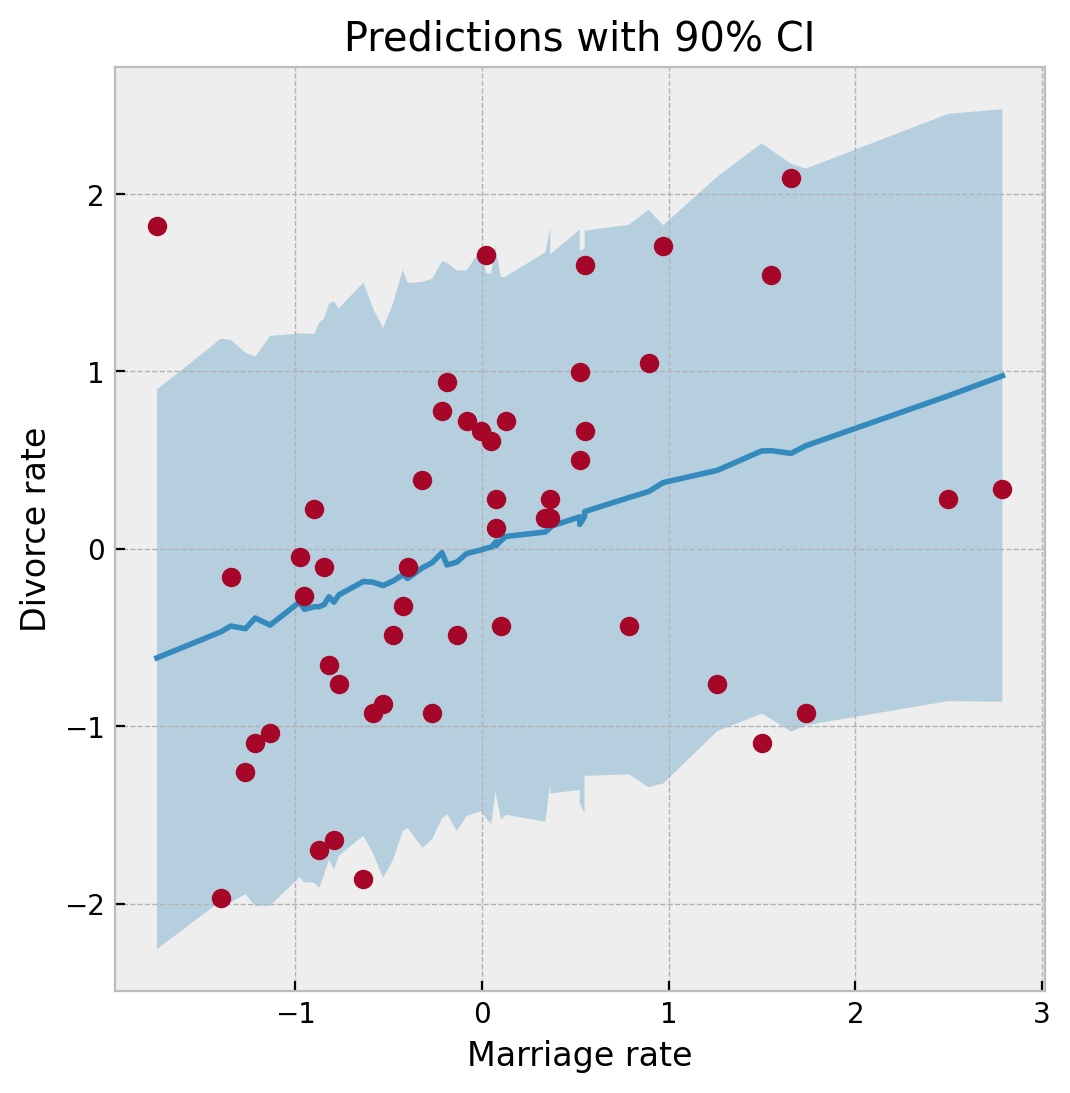

In [ ]:
hpdi_pred = hpdi(predictions_1, 0.9)

ax = plot_regression(dset.MarriageScaled.values, mean_pred, hpdi_pred)
ax.set(xlabel="Marriage rate", ylabel="Divorce rate", title="Predictions with 90% CI");

* チュートリアルにある[log likelihood](https://num.pyro.ai/en/stable/tutorials/bayesian_regression.html#Posterior-Predictive-Density)の話は、今日は割愛します。

## Hamiltonian Monte Carlo (HMC) の概説
* ここでは直感的な説明をするにとどめる。
* Stanのマニュアルを参考にした。
 * https://mc-stan.org/docs/reference-manual/hamiltonian-monte-carlo.html
* その他の参考資料
 * https://ryokamoi.github.io/blog/tech/2018/12/09/hmc

### 補助変数
* 密度関数$p(\theta)$からのサンプリングを実現したいとする。
  * $p(\theta)$については、規格化定数は不明でも構わない。
* HMCでは、補助変数$\rho$を追加し、同時分布$p(\rho, \theta) = p(\rho|\theta)p(\theta)$からのサンプリングをおこなう。
* 多くの場合（Stanでも）、$\rho$の値が従う分布は、$\theta$に依存しない多変量正規分布だと仮定する。
$$\rho \sim \text{MultiNormal}(0, M)$$
  * $M$は対角成分しか持たないらしい（Stanのマニュアル参照）。

### leapfrogアルゴリズム
* $V(\theta) \equiv - \ln p(\theta)$および$H(\rho, \theta) = - \ln p(\rho, \theta)$と定義する。
* leapfrogアルゴリズムでは、以下のように$\theta$を更新することで、サンプルのchainを作る。

1. $\rho$を$\text{MultiNormal}(0,M)$からdraw
2. 以下の一連の更新式を$L$回繰り返し実行する。
$$\begin{align}
\rho & \leftarrow \rho - \frac{\epsilon}{2}\frac{\partial V}{\partial \theta}
\notag \\
\theta & \leftarrow \theta + \epsilon M^{-1}\rho
\notag \\
\rho & \leftarrow \rho - \frac{\epsilon}{2}\frac{\partial V}{\partial \theta}
\end{align}$$
  * この結果、$\rho$は$\rho^*$へ、$\theta$は$\theta^*$へ、それぞれ更新されたとする。
3. この$\rho^*, \theta^*$を、確率$\min(1, \exp(H(\rho, \theta) - H(\rho^*, \theta^*)))$で、次のサンプルとして採用する。
  * 採用されなければ、元の$\rho,\theta$をそのまま次でも使う。



### the no-U-turn sampling (NUTS) アルゴリズム
* leapfrogアルゴリズムで、$M$と$\epsilon$と$L$は、適切に調整すべきパラメータである。
* これらのパラメータを自動的に調整するアルゴリズムとしてHoffmanとGelmanにより提案されたのが、no-U-turn sampling (NUTS)。（終）

### divergence
* leapfrogアルゴリズムは、$\frac{\partial V}{\partial \theta}$を使っている。
* 雰囲気を言うと、これは、本当なら$p(\theta)$の地形に沿って滑らかに動きたいところを、一階の微分を使って近似的に動いている。
* 近似であるため、本当ならそう動きたいという軌道から、外れてしまうこともある。
* この外れ方が非常に大きくなってしまうことを、divergenceと呼ぶ。
* divergenceが大きいと、得られたサンプルchainが所望の密度関数からのサンプルchainとみなせない。
  * MCMCの診断については、次回、説明する。

# 課題3
* 次のモデル2について、データ分析を実践してみよう。
* ヒント: 使用する説明変数を置き換えればいいだけ。

## モデル2: 婚姻年齢の中央値による予測

In [ ]:
rng_key, rng_key_ = random.split(rng_key)

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000)
mcmc.run(
    rng_key_, age=dset.AgeScaled.values, divorce=dset.DivorceScaled.values
)

sample: 100%|██████████| 3000/3000 [00:06<00:00, 487.69it/s, 3 steps of size 7.30e-01. acc. prob=0.92]


In [ ]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.00      0.10     -0.00     -0.17      0.16   1689.34      1.00
        bA     -0.57      0.11     -0.57     -0.75     -0.39   1946.29      1.00
     sigma      0.82      0.09      0.81      0.69      0.96   1727.96      1.00

Number of divergences: 0


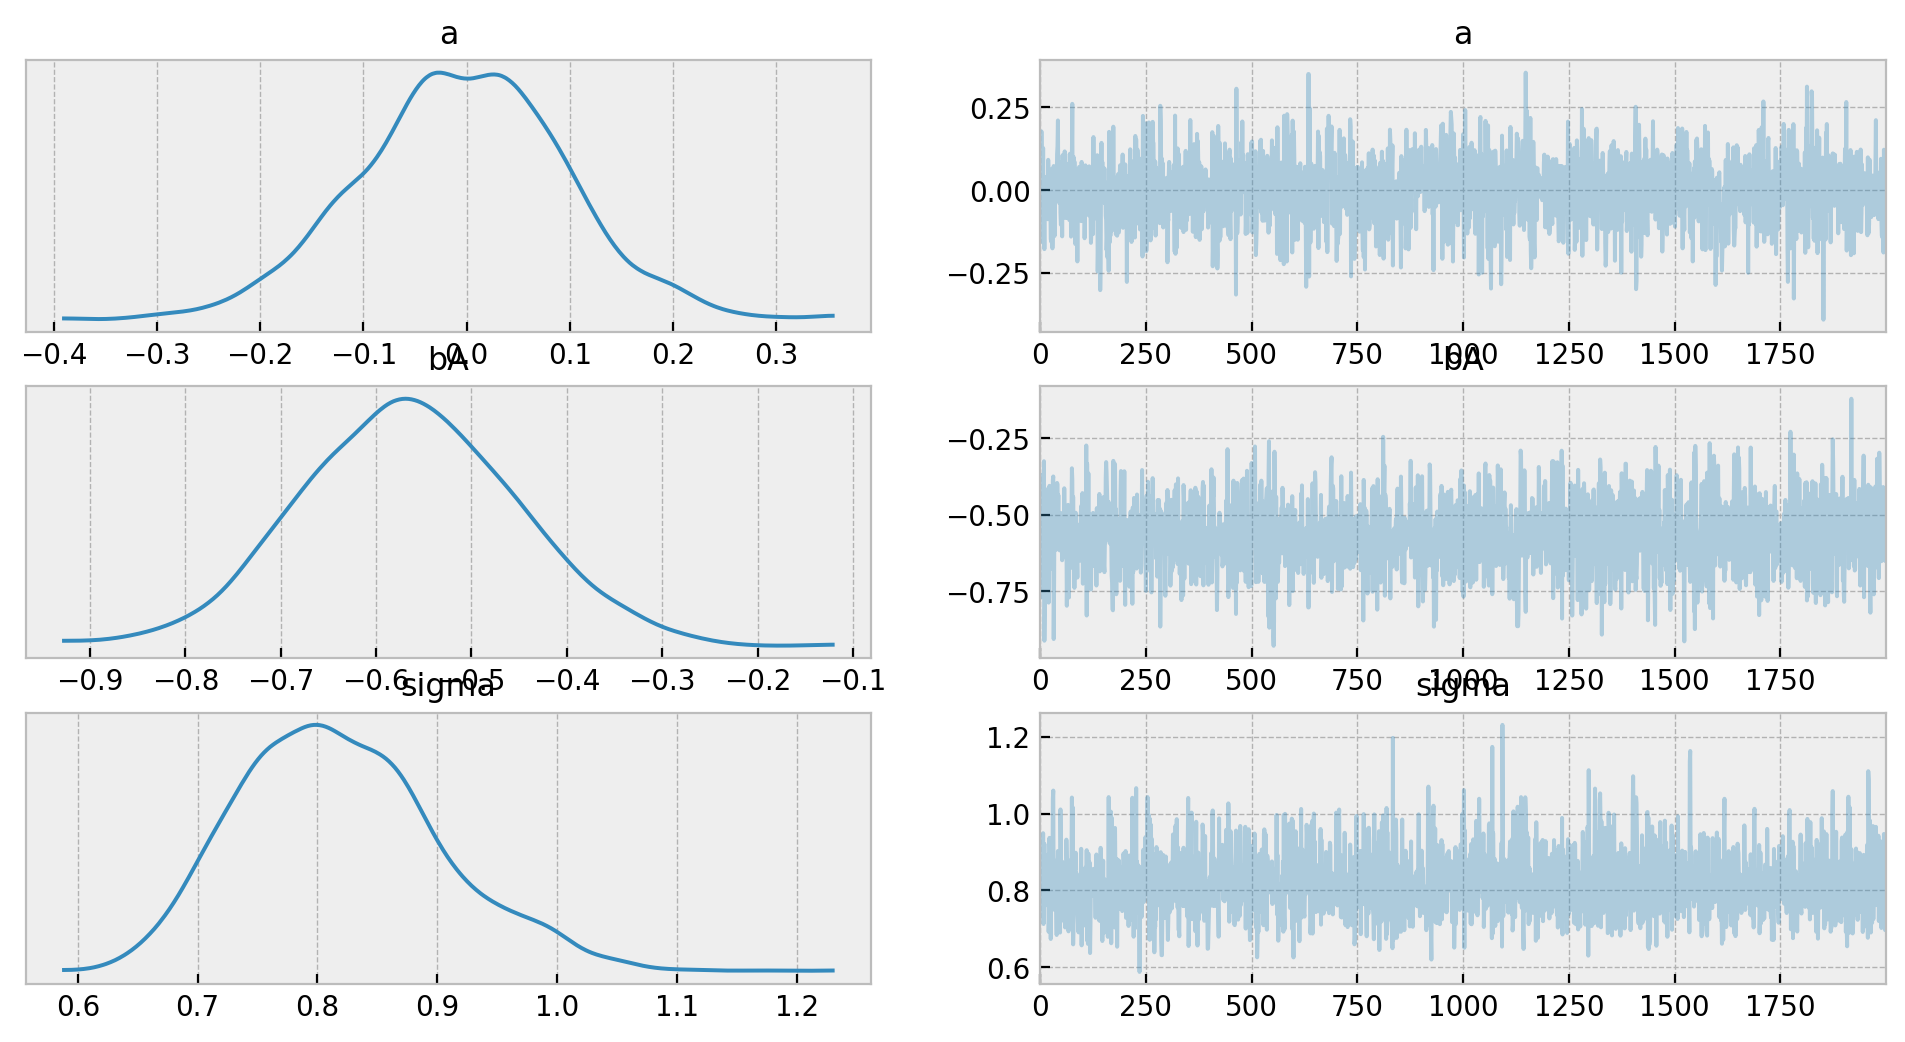

In [ ]:
import arviz as az
az.plot_trace(az.from_numpyro(mcmc));

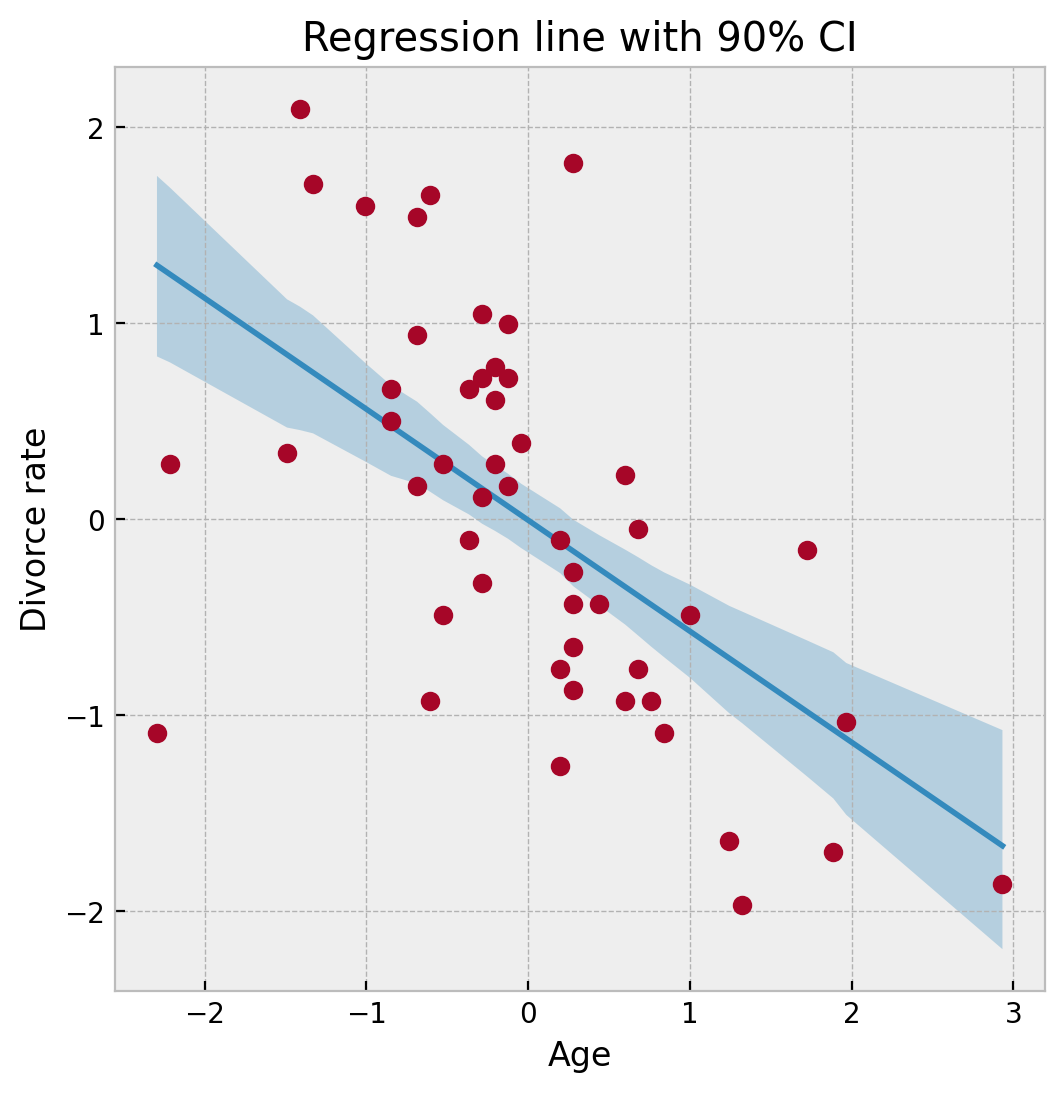

In [ ]:
samples_1 = mcmc.get_samples()

posterior_mu = (
    jnp.expand_dims(samples_1["a"], -1)
    + jnp.expand_dims(samples_1["bA"], -1) * dset.AgeScaled.values
)

mean_mu = jnp.mean(posterior_mu, axis=0)
hpdi_mu = hpdi(posterior_mu, 0.9)

ax = plot_regression(dset.AgeScaled.values, mean_mu, hpdi_mu)
ax.set(
    xlabel="Age", ylabel="Divorce rate", title="Regression line with 90% CI",
);

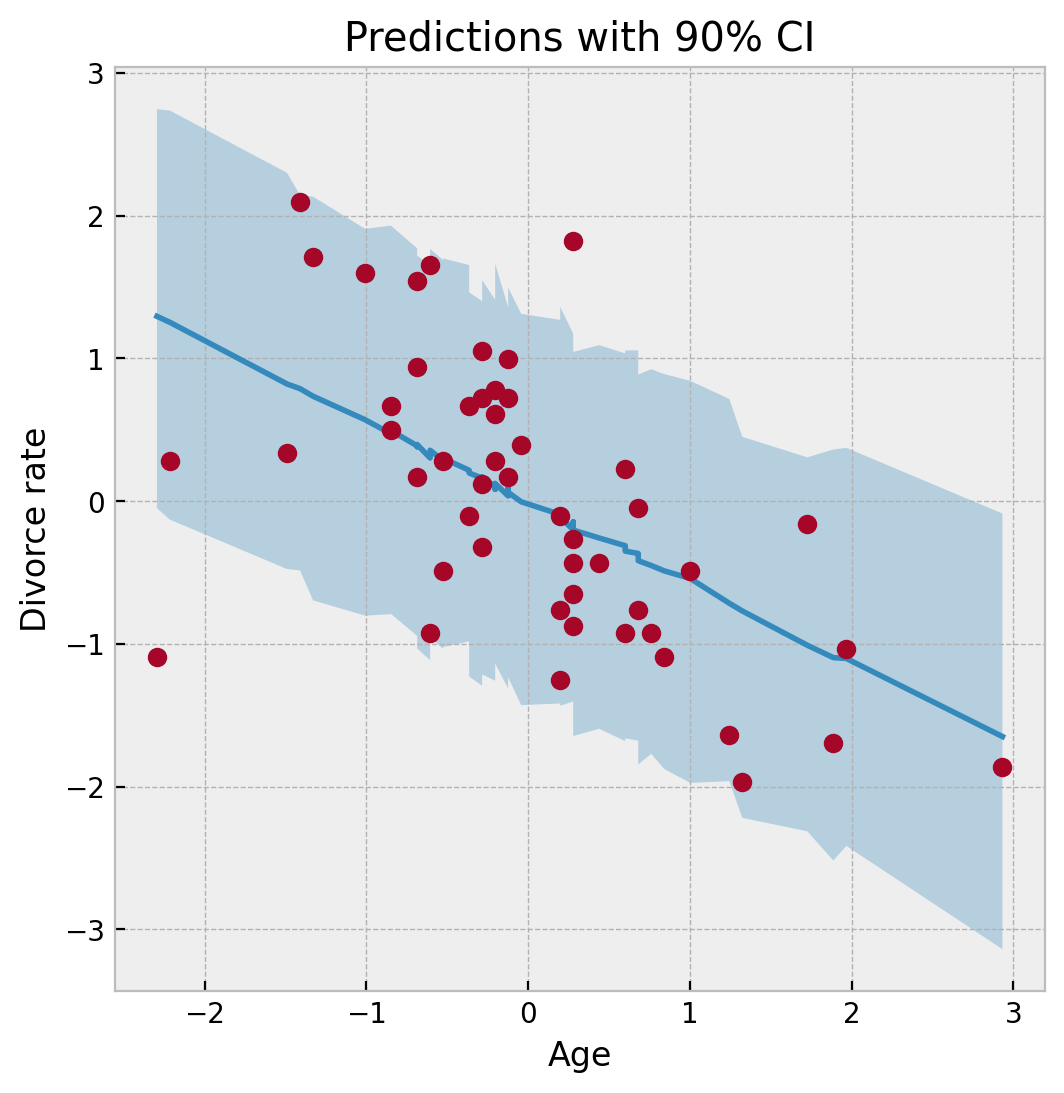

In [ ]:
rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model, samples_1) # ここで予測分布を作っている
predictions_1 = predictive(rng_key_, age=dset.AgeScaled.values)["obs"]

mean_pred = jnp.mean(predictions_1, axis=0)

hpdi_pred = hpdi(predictions_1, 0.9)

ax = plot_regression(dset.AgeScaled.values, mean_pred, hpdi_pred)
ax.set(xlabel="Age", ylabel="Divorce rate", title="Predictions with 90% CI");

## モデル3: 両変数を使ったモデル

In [ ]:
rng_key, rng_key_ = random.split(rng_key)

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000)
mcmc.run(
    rng_key_,
    age=dset.AgeScaled.values,
    marriage=dset.MarriageScaled.values,
    divorce=dset.DivorceScaled.values
)

sample: 100%|██████████| 3000/3000 [00:08<00:00, 369.00it/s, 3 steps of size 5.37e-01. acc. prob=0.93] 


In [ ]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.00      0.10      0.00     -0.16      0.18   1847.96      1.00
        bA     -0.62      0.15     -0.62     -0.87     -0.38   1010.37      1.00
        bM     -0.07      0.16     -0.07     -0.32      0.19   1221.79      1.00
     sigma      0.83      0.08      0.82      0.69      0.96   1558.18      1.00

Number of divergences: 0


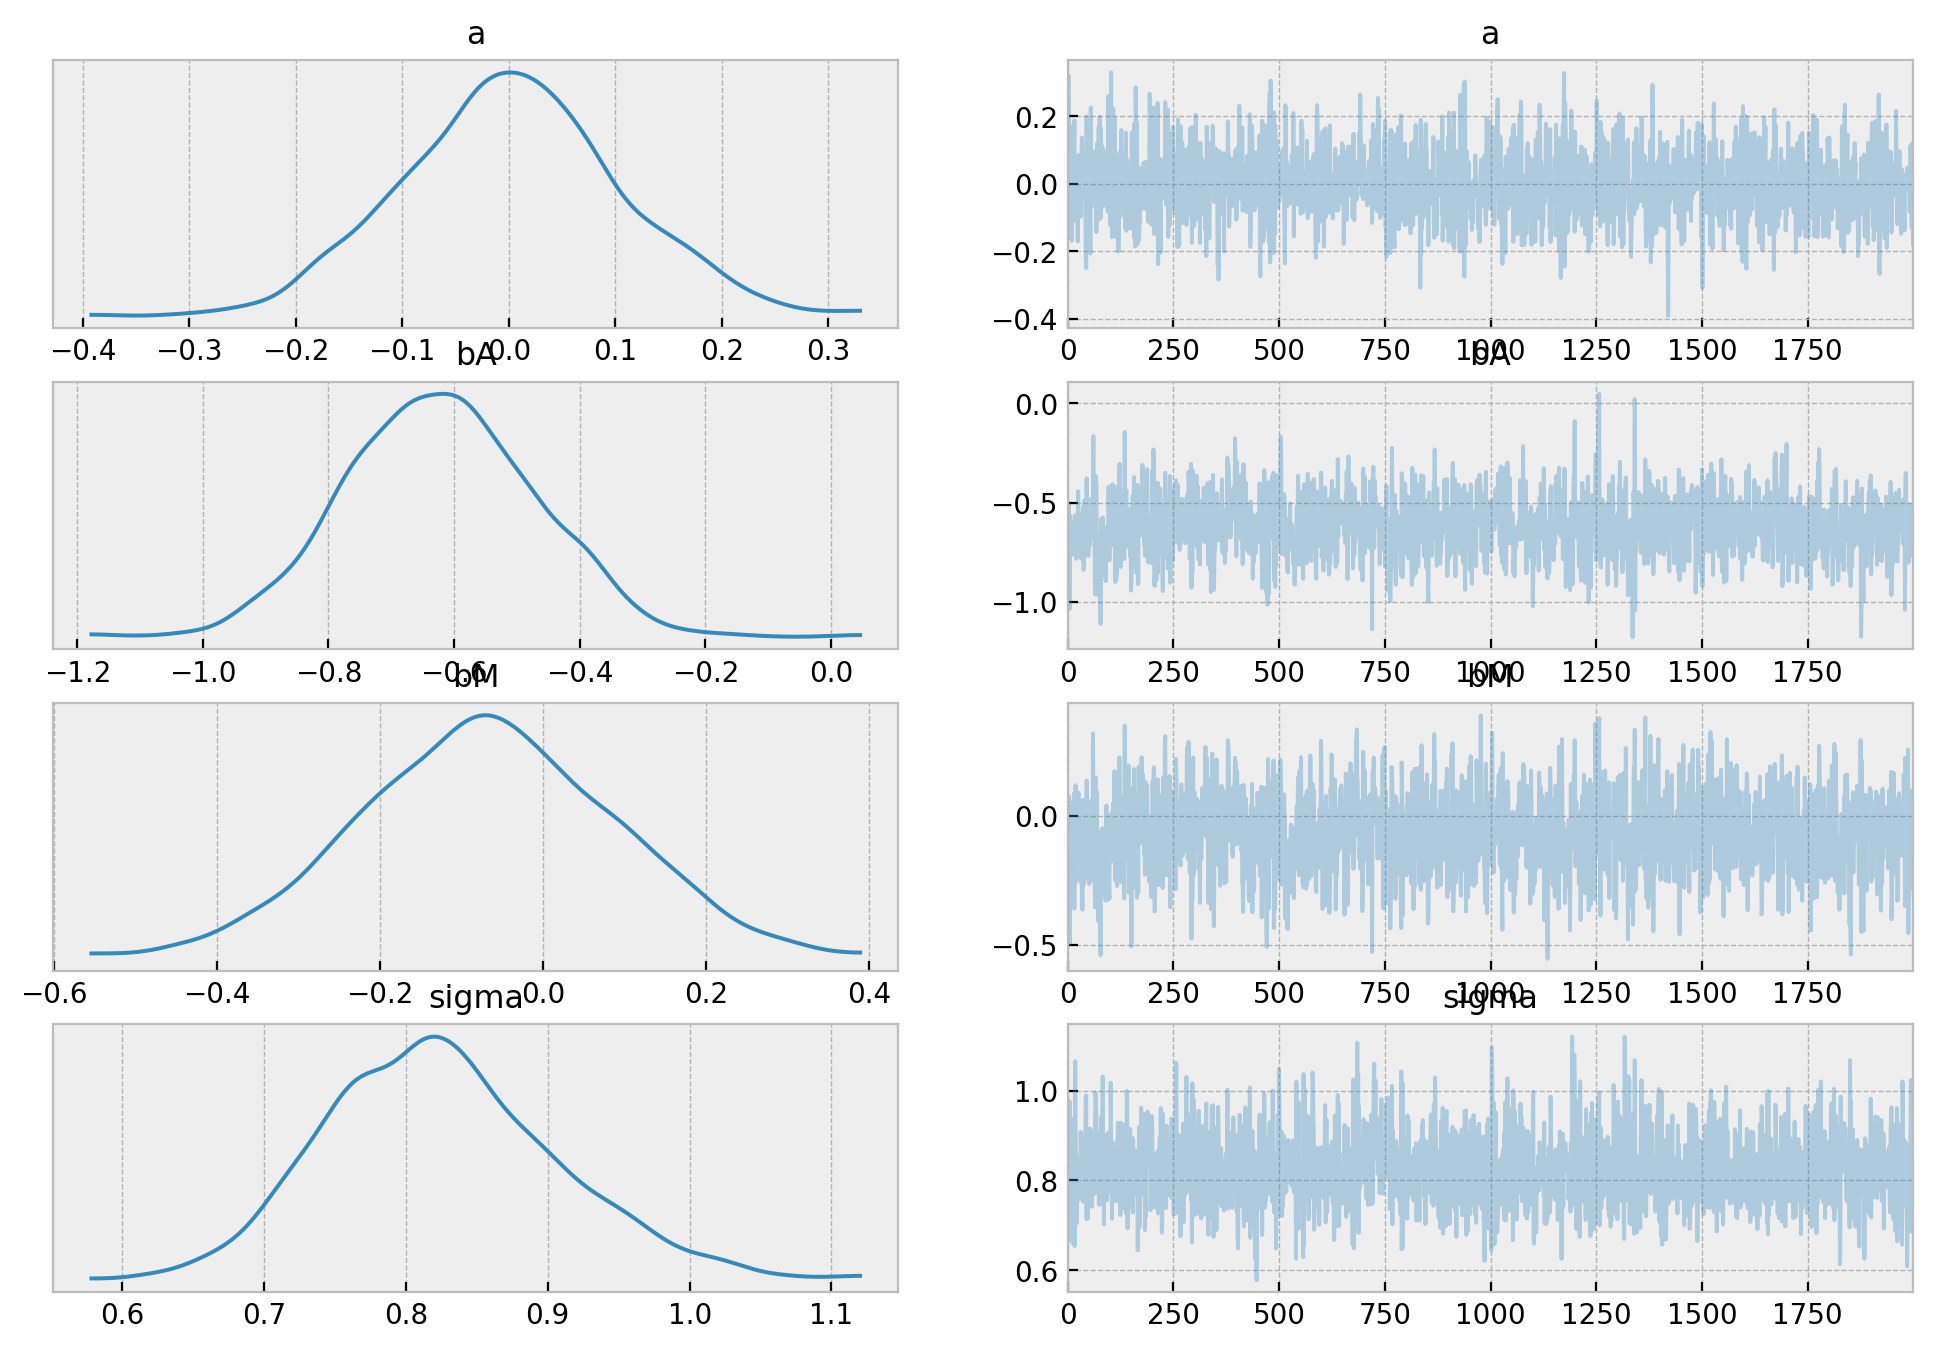

In [ ]:
import arviz as az
az.plot_trace(az.from_numpyro(mcmc));

In [ ]:
samples_1 = mcmc.get_samples()

posterior_mu = (
    jnp.expand_dims(samples_1["a"], -1)
    + jnp.expand_dims(samples_1["bM"], -1) * dset.MarriageScaled.values
    + jnp.expand_dims(samples_1["bA"], -1) * dset.AgeScaled.values
)

mean_mu = jnp.mean(posterior_mu, axis=0)
hpdi_mu = hpdi(posterior_mu, 0.9)

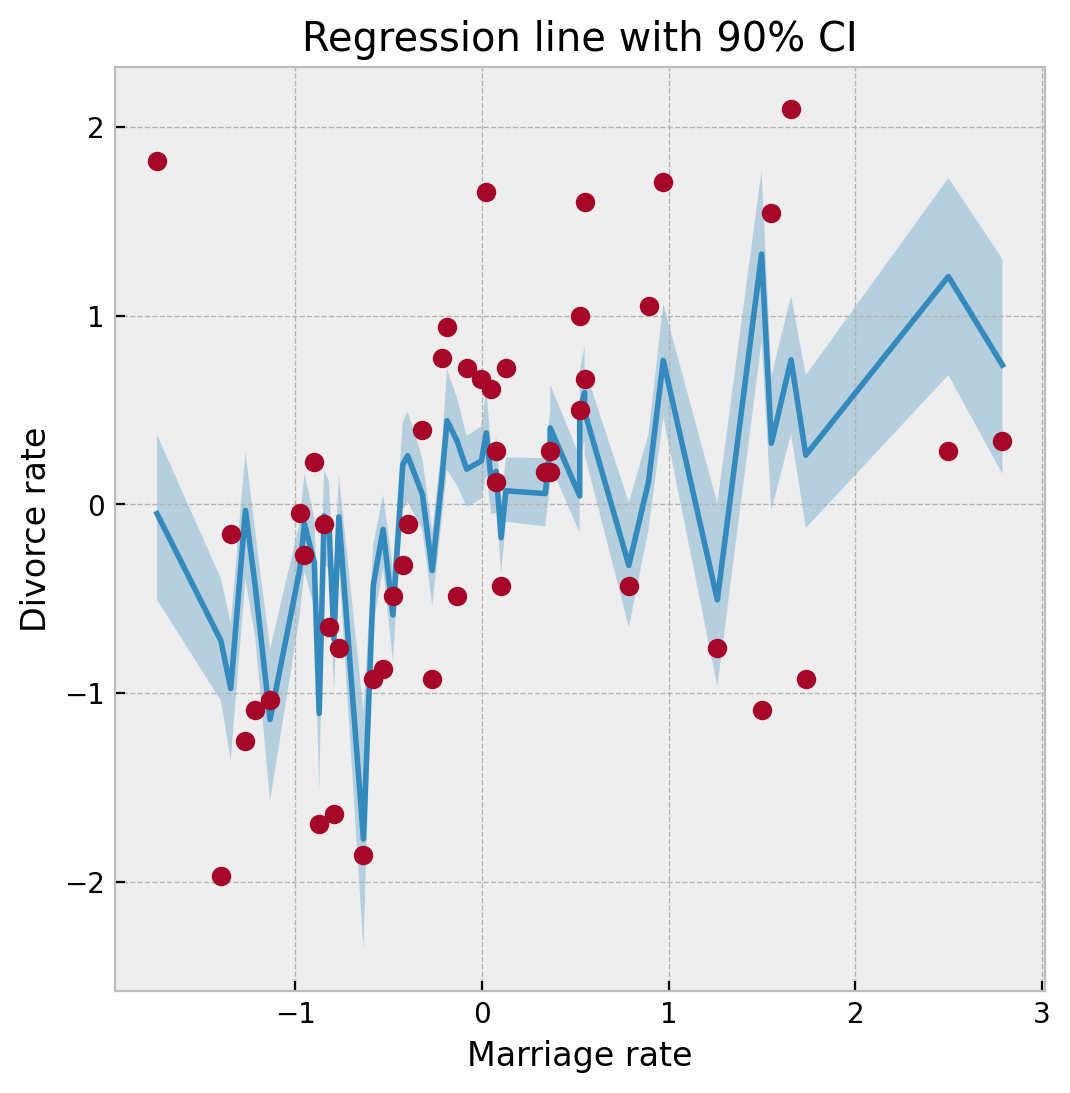

In [ ]:
ax = plot_regression(dset.MarriageScaled.values, mean_mu, hpdi_mu)
ax.set(
    xlabel="Marriage rate", ylabel="Divorce rate", title="Regression line with 90% CI",
);

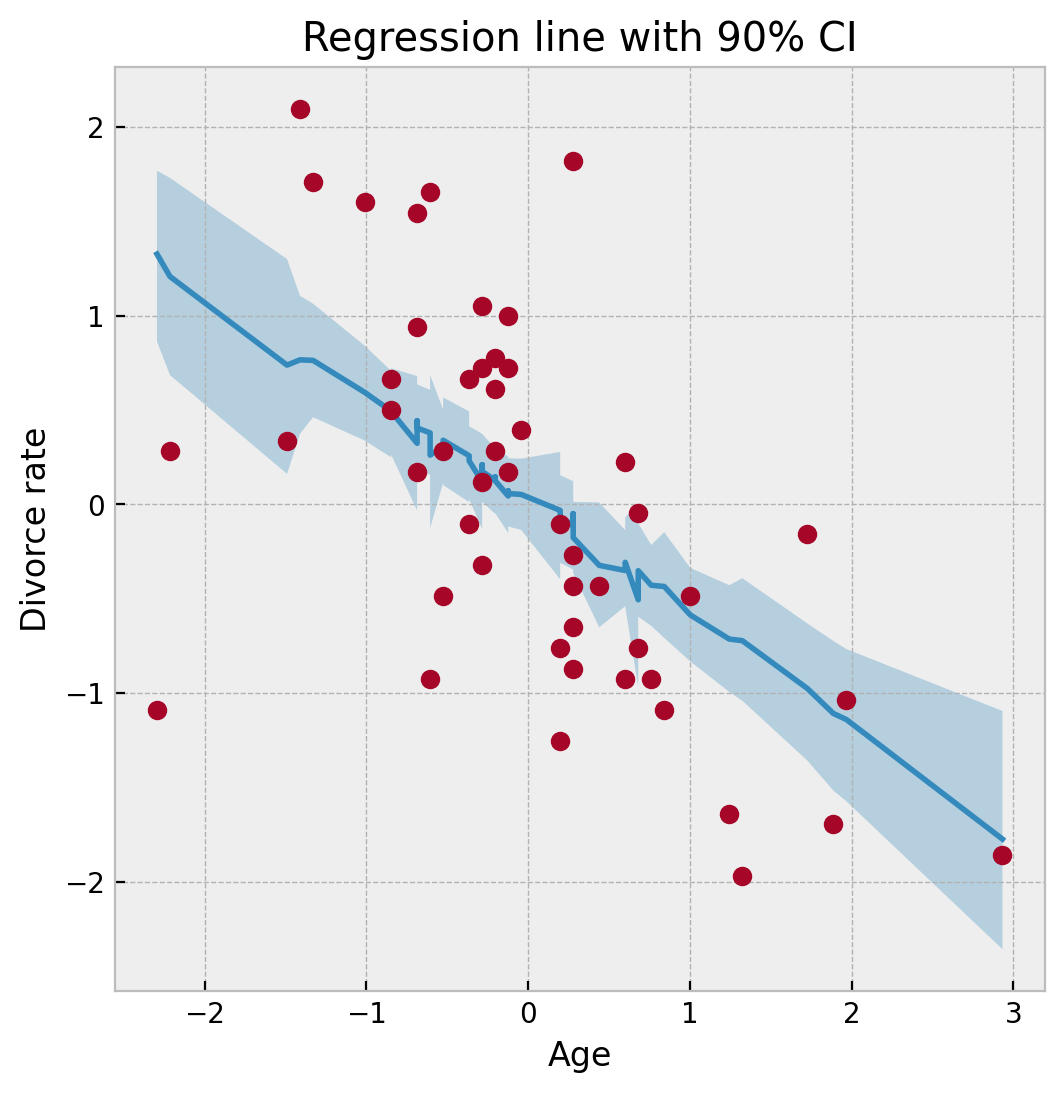

In [ ]:
ax = plot_regression(dset.AgeScaled.values, mean_mu, hpdi_mu)
ax.set(
    xlabel="Age", ylabel="Divorce rate", title="Regression line with 90% CI",
);

In [ ]:
rng_key, rng_key_ = random.split(rng_key)
kernel = NUTS(model)
mcmc1 = MCMC(kernel, num_warmup=1000, num_samples=2000)
mcmc1.run(
    rng_key_, age=dset.AgeScaled.values, divorce=dset.DivorceScaled.values
)

rng_key, rng_key_ = random.split(rng_key)
kernel = NUTS(model)
mcmc2 = MCMC(kernel, num_warmup=1000, num_samples=2000)
mcmc2.run(
    rng_key_,
    age=dset.AgeScaled.values,
    marriage=dset.MarriageScaled.values,
    divorce=dset.DivorceScaled.values
)

sample: 100%|██████████| 3000/3000 [00:07<00:00, 389.04it/s, 7 steps of size 5.99e-01. acc. prob=0.90] 


In [ ]:
samples_1 = az.from_numpyro(mcmc1)
samples_2 = az.from_numpyro(mcmc2)

In [ ]:
df_comp = az.compare({'model_1': samples_1, 'model_2': samples_2}, var_name="obs")
df_comp

/home/masada/anaconda3/lib/python3.11/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_1,0,-62.922884,3.680040,0.000000,1.0,6.285830,0.000000,False,log
model_2,1,-63.686455,4.648683,0.763571,0.0,6.364349,0.376011,True,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

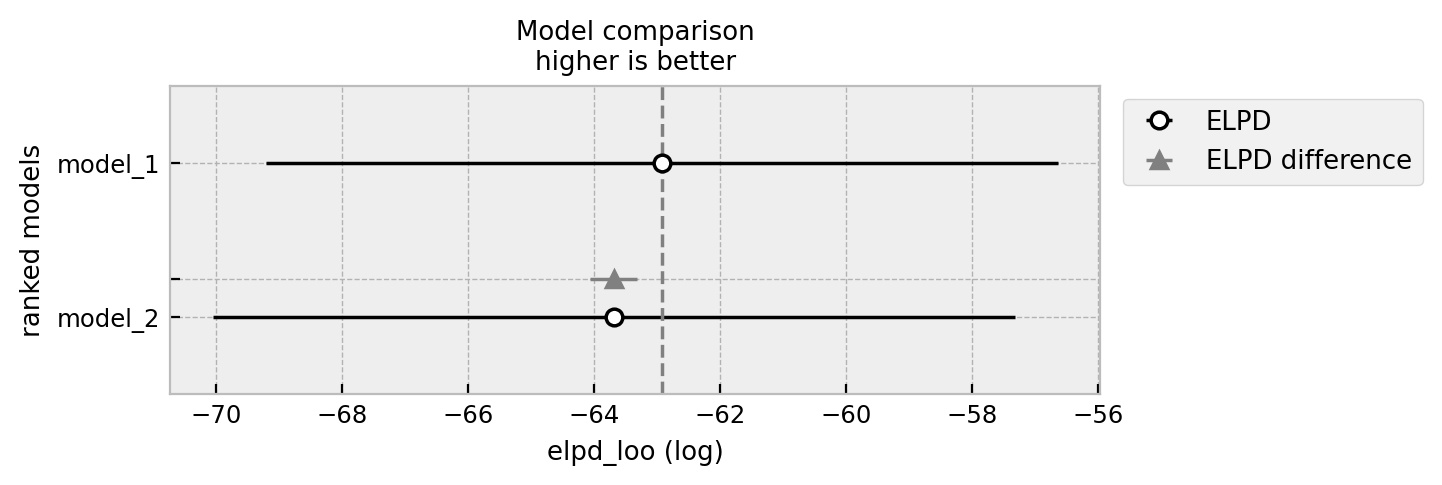

In [ ]:
az.plot_compare(df_comp)